In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import math
import os
from scipy.special import legendre

In [2]:
radian = 180/math.pi
lmax = 64
random_map_number=100

In [3]:
NSIDE = 256
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 256 is 0.23 deg


In [4]:
NPIX = hp.nside2npix(NSIDE)
#print(NPIX)

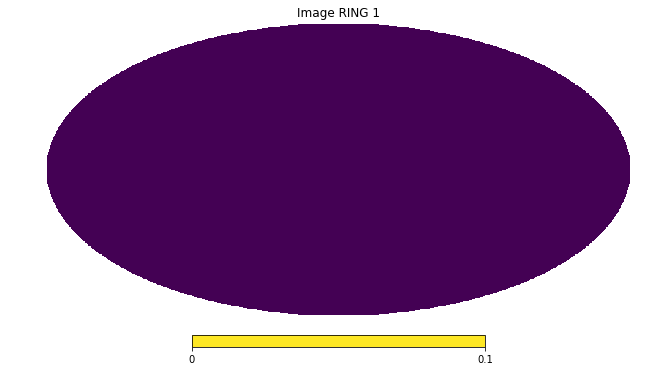

In [5]:
m = np.zeros(NPIX)
hp.mollview(
    m, 
    title="Image RING 1",
    norm="hist",
    min=0,
    max=0.1)


In [6]:
vec = hp.ang2vec(np.random.random()*np.pi,np.random.random()*2.*np.pi)
print(vec)

[-0.10624793  0.95541886  0.27547446]


In [8]:
m = np.zeros(NPIX)
for i in range(10):
    vec = hp.ang2vec(np.random.random()*np.pi,np.random.random()*2.*np.pi)
    ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(10))
    m[ipix_disc] = 0.1

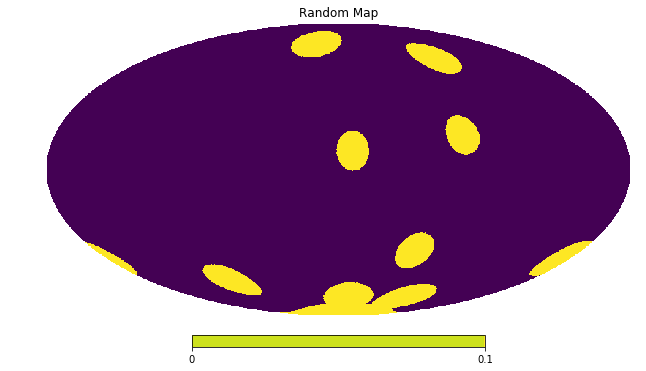

In [10]:
hp.mollview(
    m,
    title="Random Map",
    norm="hist",
    min=0,
    max=0.1)

In [11]:
def PLcos(l,theta):
    PL=legendre(l)
    return PL(np.cos(theta))

In [12]:
def corr_function(map,lmax,theta):
    alm = hp.map2alm(map, lmax = lmax)
    cl = np.zeros(lmax+1,dtype='double')
    al2 = np.zeros(lmax+1,dtype='cdouble')
    l = 0
    while l < lmax+1:
        al2[l] = alm[l]*np.conj(alm[l]) 
        j = 0
        k = 0
        while j < l:
            k += lmax-j
            #print(l,l+k)
            al2[l] = al2[l] + 2*alm[l+k]*np.conj(alm[l+k])
            j += 1
        if al2.imag.any(): print('Warning! al2 array is complex.')    
        cl[l] = al2[l].real * PLcos(l,theta)    
        l += 1
    ctheta = np.sum(cl)/4/np.pi
    return ctheta

In [14]:
theta_values = np.linspace(0,np.pi,100)
corr_function_theta = []
for theta in theta_values:
    corr_function_theta.append(corr_function(m,lmax,theta))

In [16]:
corr_function_theta_background = np.zeros(len(theta_values))
corr_function_theta_background_norm = np.zeros(len(theta_values))
for random_index in range(0,random_map_number):
    corr_function_theta_random = np.array([])
    for theta in theta_values:
        corr_function_theta_random = np.append(corr_function_theta_random,corr_function(m,lmax,theta))
    corr_function_theta_background += corr_function_theta_random 
corr_function_theta_background_norm = np.divide(corr_function_theta_background,random_map_number)   

In [17]:
corr_function_theta_background_stdev_square = np.zeros(len(theta_values))
corr_function_theta_background_norm_stdev_square = np.zeros(len(theta_values))
corr_function_theta_background_norm_stdev = np.zeros(len(theta_values))
for random_index in range(0,random_map_number):
    corr_function_theta_random = np.array([])
    for theta in theta_values:
        corr_function_theta_random = np.append(corr_function_theta_random,corr_function(m,lmax,theta))
    corr_function_theta_background_stdev_square += np.square(corr_function_theta_random-corr_function_theta_background_norm) 
corr_function_theta_background_norm_stdev_square = np.divide(corr_function_theta_background_stdev_square,random_map_number-1)
corr_function_theta_background_norm_stdev = np.sqrt(corr_function_theta_background_norm_stdev_square)

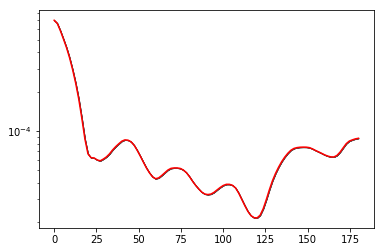

In [18]:
fig, ax = plt.subplots()
plt.yscale('log')
k = 1
plt.plot(theta_values*180/np.pi,corr_function_theta,color='r');
while k < 6:
    plt.fill_between(theta_values*180/np.pi,corr_function_theta_background_norm+k*corr_function_theta_background_norm_stdev,corr_function_theta_background_norm-k*corr_function_theta_background_norm_stdev,color='k',alpha=0.3-(k-1)*0.05)
    k+=1

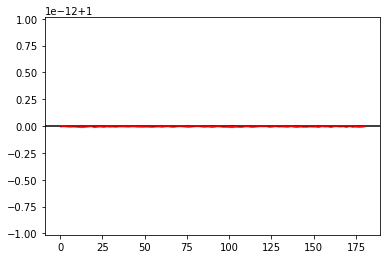

In [21]:
fig, ax = plt.subplots()
ax.axhline(y=1, color='k')
ax.plot(theta_values*180/np.pi,corr_function_theta/corr_function_theta_background_norm,color='r');
k = 1
while k < 6:
    ax.fill_between(theta_values*180/np.pi,(corr_function_theta_background_norm+k*corr_function_theta_background_norm_stdev)/corr_function_theta_background_norm,(corr_function_theta_background_norm-k*corr_function_theta_background_norm_stdev)/corr_function_theta_background_norm,color='k',alpha=0.3-(k-1)*0.05);
    k+=1